11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - kl_loss: 6.9969 - loss: 200.5862 - reconstruction_loss: 193.5893
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - kl_loss: 3.1697 - loss: 169.8130 - reconstruction_loss: 166.6433
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - kl_loss: 3.2000 - loss: 165.8004 - reconstruction_loss: 162.6003
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - kl_loss: 3.2808 - loss: 163.1973 - reconstruction_loss: 159.9166
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - kl_loss: 3.3406 - loss: 161.2889 - reconstruction_loss: 157.9483
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - kl_loss: 3.3616 - loss: 159.8339 - reconstruction_loss: 156.4723
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - kl_loss: 3.3963 - loss: 158.7370 - reconstruction_loss: 155.3406
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - kl_loss: 3.3883 - loss: 157.8707 - reconstruction

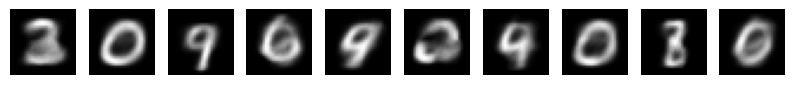

In [ ]:
import numpy as np, tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K

(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_train = x_train.reshape(-1, 28*28)

latent_dim = 2  # latent space size

# Encoder
class Encoder(layers.Layer):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.dense1 = layers.Dense(256, activation='relu')
        self.z_mean = layers.Dense(latent_dim)
        self.z_log_var = layers.Dense(latent_dim)

    def call(self, inputs):
        h = self.dense1(inputs)
        z_mean = self.z_mean(h)
        z_log_var = self.z_log_var(h)
        return z_mean, z_log_var

# Decoder
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(256, activation='relu')
        self.output_layer = layers.Dense(784, activation='sigmoid')

    def call(self, inputs):
        h = self.dense1(inputs)
        return self.output_layer(h)

# VAE Model
class VAE(Model):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def sample(self, z_mean, z_log_var):
        eps = K.random_normal(shape=tf.shape(z_mean))
        return z_mean + K.exp(0.5 * z_log_var) * eps

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sample(z_mean, z_log_var)
            reconstruction = self.decoder(z)
            recon_loss = K.mean(
                K.binary_crossentropy(data, reconstruction)
            ) * 784
            kl_loss = -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
            total_loss = recon_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {
            "loss": total_loss,
            "reconstruction_loss": recon_loss,
            "kl_loss": kl_loss,
        }

encoder = Encoder(latent_dim)
decoder = Decoder()
vae = VAE(encoder, decoder)

# Compile and Train
vae.compile(optimizer='adam')
vae.fit(x_train, x_train, epochs=10, batch_size=128, verbose=1)

# Generate New Images
import matplotlib.pyplot as plt
z_samples = tf.random.normal((10, latent_dim))
gen_imgs = decoder(z_samples).numpy().reshape(-1,28,28)
plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(gen_imgs[i], cmap='gray'); plt.axis('off')
plt.show()
